# Examen 3 Práctico
## Arantza Gomez Haro Gamboa

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve

In [2]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos:**

In [3]:
df = pd.read_csv('hr_role.csv')
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df)

target = 'Attrition'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Árbol Max Depth 2**

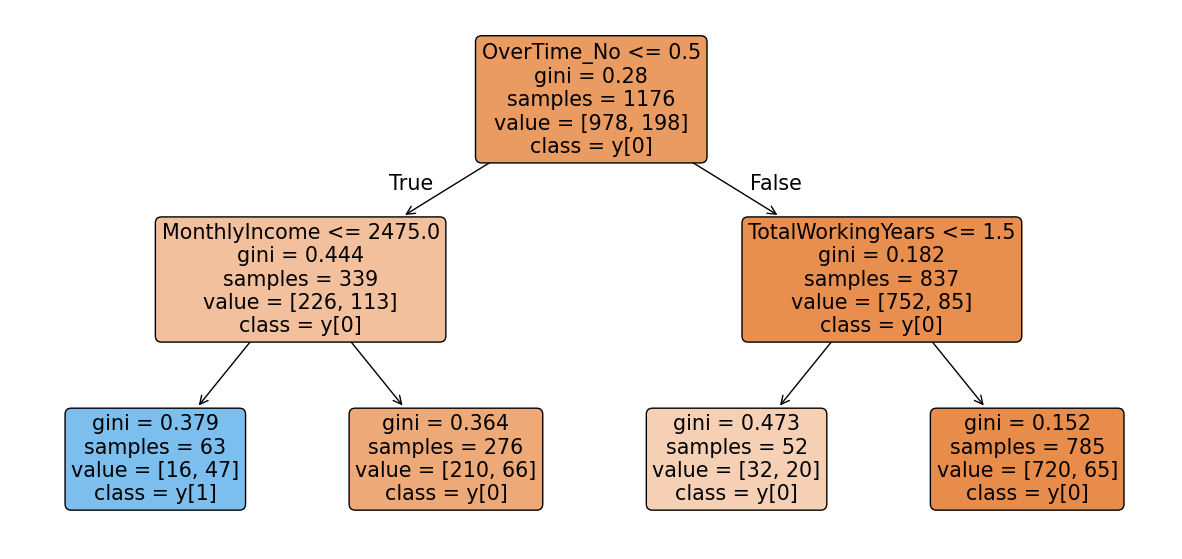

In [5]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
plt.figure(figsize=(15, 7))
plot_tree(tree, feature_names=X.columns, filled = True, rounded = True, class_names=True)
plt.show()

##### *Análisis:*

### **Mejor Árbol**

In [6]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier())
])

params = {
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13],
    'tree__min_samples_split': [2,3,4,5,6,7,8,9,10],
    'tree__min_samples_leaf': [1,2,3,4,5],
    'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5]
}

grid_tree = GridSearchCV(estimator = pipeline, cv=5, n_jobs=-1, scoring = 'roc_auc', param_grid = params)
grid_tree.fit(X_train, y_train)

c:\Users\arant\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13],
                         'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='roc_auc')

In [7]:
grid_tree.best_params_

{'tree__max_depth': 4,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 4}

In [8]:
best_model = grid_tree.best_estimator_.named_steps['tree']
predicciones = best_model.predict_proba(X_test)[:,1]
auc_dtc = roc_auc_score(y_score=predicciones, y_true=y_test)

##### *Feature Importance:*

In [9]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
52,OverTime_Yes,0.294772
7,JobLevel,0.269014
8,MonthlyIncome,0.201911
15,StockOptionLevel,0.098552
49,MaritalStatus_Single,0.043176
2,DistanceFromHome,0.039055
19,YearsAtCompany,0.026051
17,TrainingTimesLastYear,0.009760
41,JobRole_Manager,0.009426
30,EducationField_Human Resources,0.008283


##### *Análisis:*

### **Modelos:**

#### Random Forest

In [10]:
len(X_train.keys())

53

In [11]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=300, n_jobs = -1))
])

params = {
    'rf__max_depth': [20, 25, 20, 35, 40],
    'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs = -1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_estimators=300,
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 25, 20, 35, 40],
                         'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]},
             scoring='roc_auc')

In [12]:
rf_grid.best_params_

{'rf__max_depth': 20, 'rf__max_features': 'log2'}

In [13]:
best_model =rf_grid.best_estimator_.named_steps['rf']
predicciones_rf = best_model.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_score=predicciones_rf, y_true=y_test)

##### *Feature Importance:*

In [14]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.072643
0,Age,0.051104
16,TotalWorkingYears,0.048619
1,DailyRate,0.046638
9,MonthlyRate,0.046592
19,YearsAtCompany,0.043257
5,HourlyRate,0.043132
51,OverTime_No,0.040585
2,DistanceFromHome,0.039049
52,OverTime_Yes,0.035149


##### *Análisis:*

#### XGBoost:

In [15]:
model = XGBClassifier(
    n_estimators = 100_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-logloss:0.42412	validation_1-logloss:0.38659
[76]	validation_0-logloss:0.09359	validation_1-logloss:0.34528


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [01:19:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

In [16]:
predicciones_xg = model.predict_proba(X_test)[:,1]
auc_xg = roc_auc_score(y_score=predicciones_xg, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

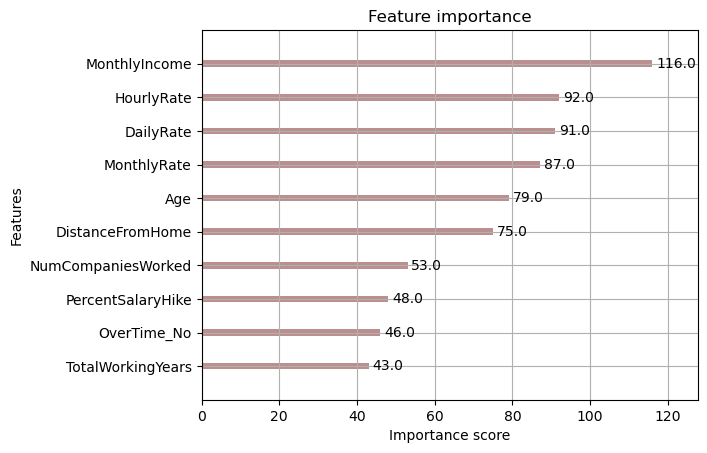

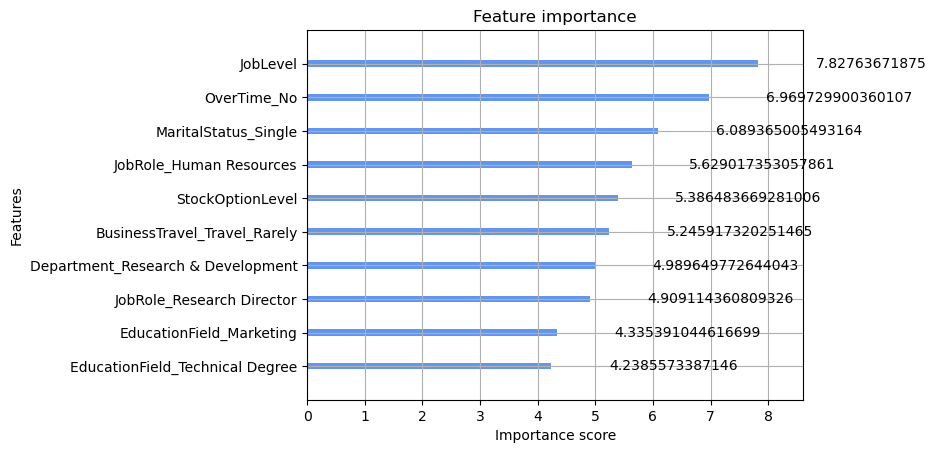

In [17]:
plot_importance(model, max_num_features=10, importance_type="weight", color = 'rosybrown')
plot_importance(model, max_num_features=10, importance_type="gain", color = 'cornflowerblue')

#### LightGBM:

In [18]:
model = LGBMClassifier(
    n_estimators=100_000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(40),
                     log_evaluation(100)])

Training until validation scores don't improve for 40 rounds
[100]	training's rmse: 0.161325	training's binary_logloss: 0.117939	valid_1's rmse: 0.306725	valid_1's binary_logloss: 0.322622
Early stopping, best iteration is:
[77]	training's rmse: 0.189117	training's binary_logloss: 0.147445	valid_1's rmse: 0.307034	valid_1's binary_logloss: 0.322332


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=100000, num_leaves=10, subsample=0.8, verbosity=-1)

In [19]:
predicciones_light = model.predict_proba(X_test)[:,1]
auc_light = roc_auc_score(y_score=predicciones_light, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

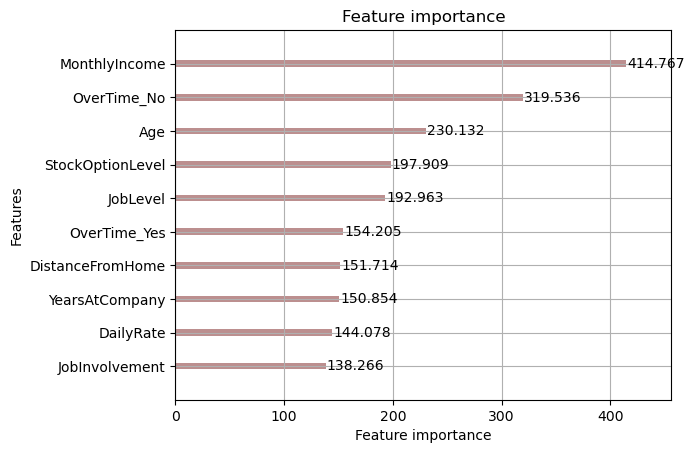

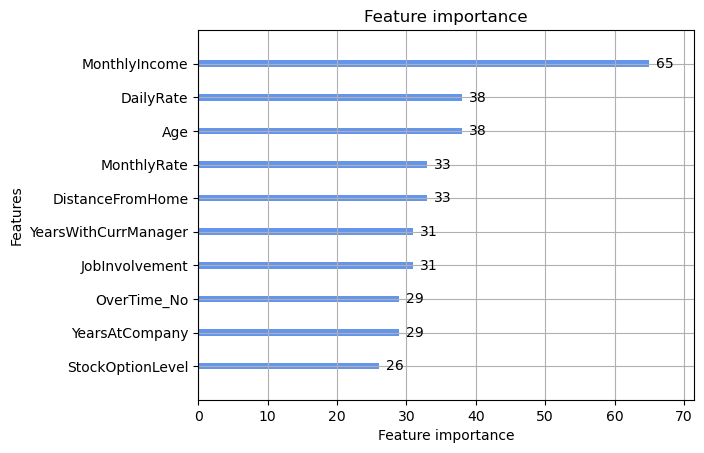

In [20]:
lgb.plot_importance(model, max_num_features = 10, importance_type='gain', color = 'rosybrown')
lgb.plot_importance(model, max_num_features = 10, importance_type='split', color = 'cornflowerblue')

#### CatBoost

In [21]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [22]:
model = CatBoostClassifier(
    iterations=100_000,         
    depth=5,                   
    learning_rate=0.1,
    subsample=0.5,             
    rsm=0.8,                  
    eval_metric='AUC',
    early_stopping_rounds=40,
    verbose = 100)           

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

predicciones_catboost = model.predict_proba(X_test)[:,1]
auc_cat = roc_auc_score(y_score=predicciones_catboost, y_true=y_test)

0:	test: 0.5547009	best: 0.5547009 (0)	total: 188ms	remaining: 5h 13m 51s
100:	test: 0.7710407	best: 0.7710407 (100)	total: 6.45s	remaining: 1h 46m 18s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.7733534439
bestIteration = 104

Shrink model to first 105 iterations.


In [23]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
})

#.sort_values(by='importance', ascending=False)
importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.072643
0,Age,0.051104
16,TotalWorkingYears,0.048619
1,DailyRate,0.046638
9,MonthlyRate,0.046592
19,YearsAtCompany,0.043257
5,HourlyRate,0.043132
51,OverTime_No,0.040585
2,DistanceFromHome,0.039049
52,OverTime_Yes,0.035149


### **Gráficas de Calibración:**

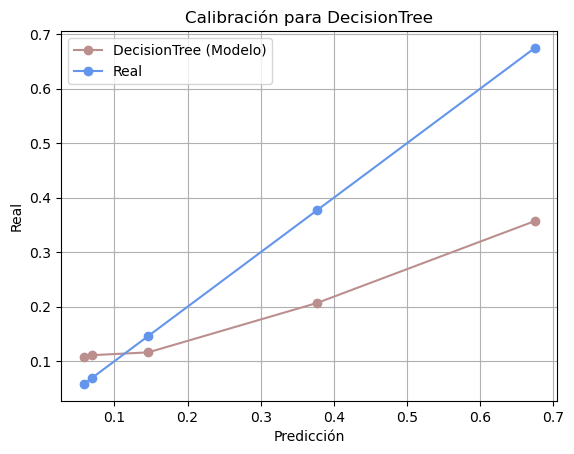

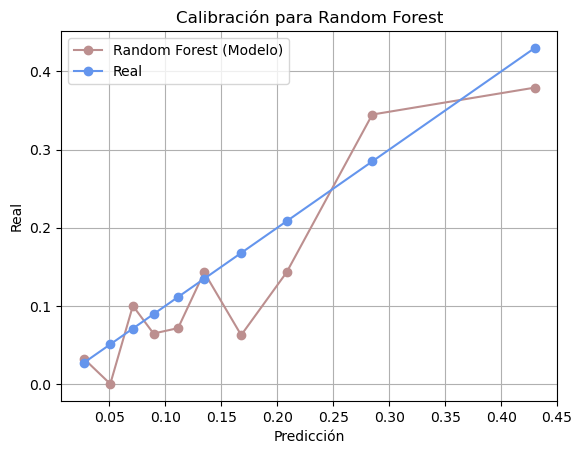

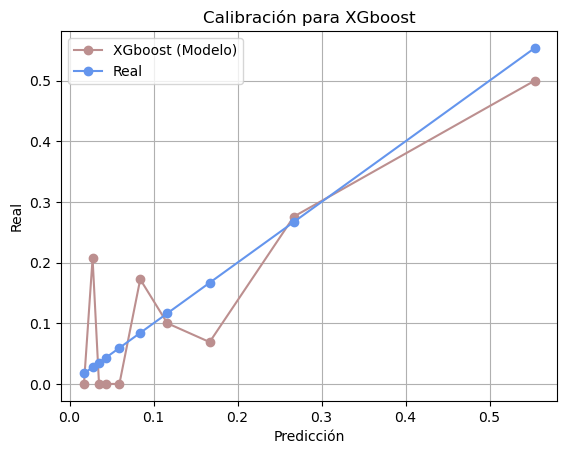

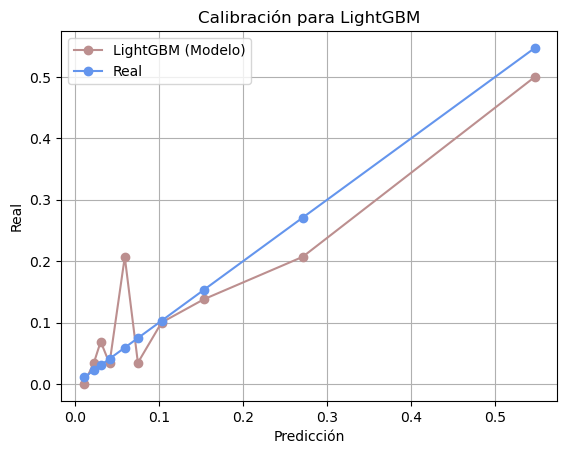

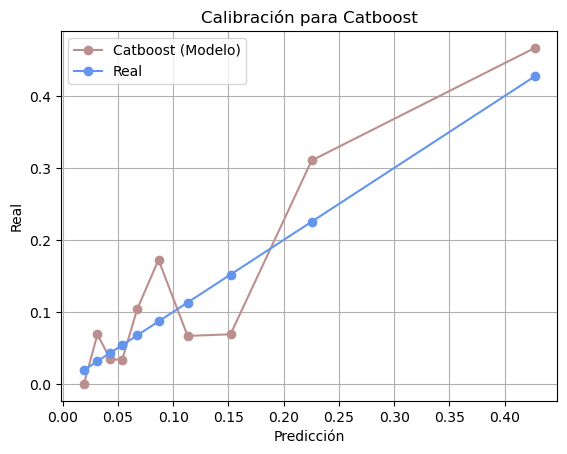

In [24]:
modelos = {
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGboost': predicciones_xg,
    'LightGBM': predicciones_light,
    'Catboost': predicciones_catboost,
}

calibracion_multiple(modelos, y_test, bins=10)

### **Histogramas:**

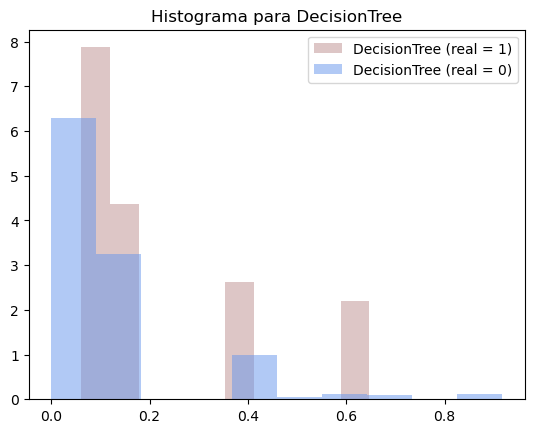

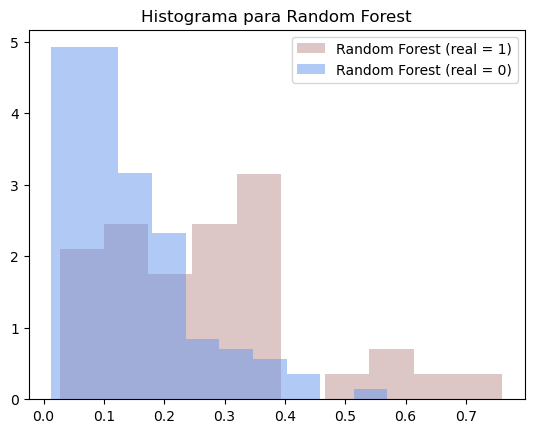

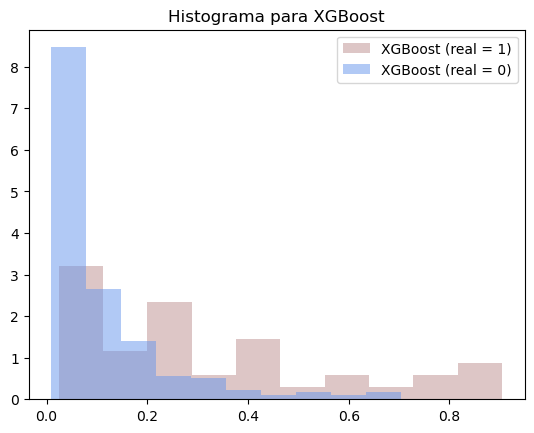

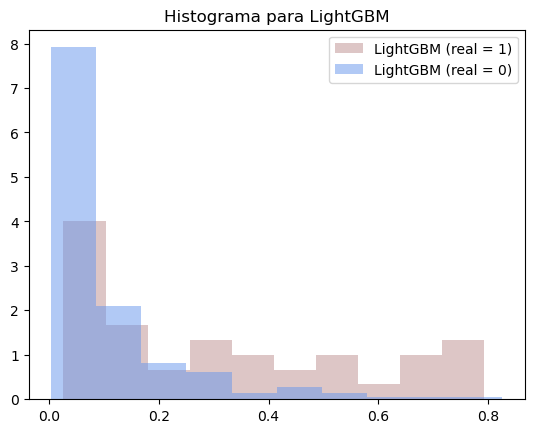

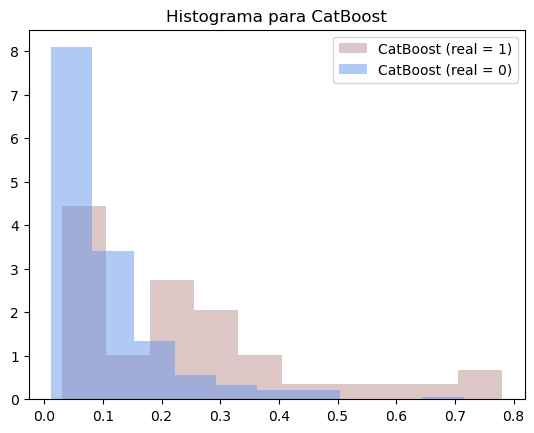

In [25]:
histogramas = pd.DataFrame({
    'real': y_test,
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGBoost': predicciones_xg,
    'LightGBM': predicciones_light,
    'CatBoost': predicciones_catboost,
})

real1 = histogramas[histogramas['real'] == 1]
real0 = histogramas[histogramas['real'] == 0]

modelos = ['DecisionTree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

for modelo in modelos:
    plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='rosybrown', label=f'{modelo} (real = 1)')
    plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='cornflowerblue', label=f'{modelo} (real = 0)')
    plt.title(f'Histograma para {modelo}')
    plt.legend()
    plt.show()

### **Curva ROC:**

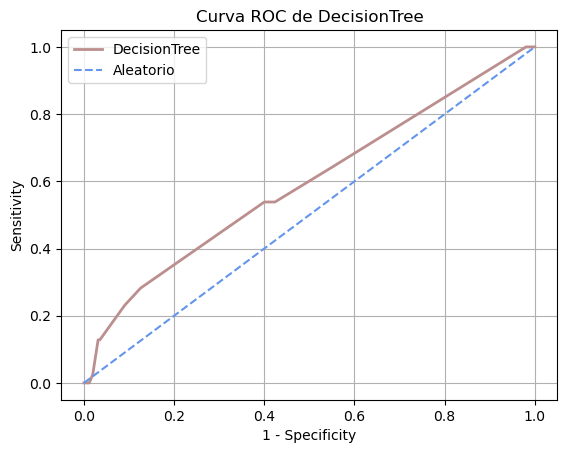

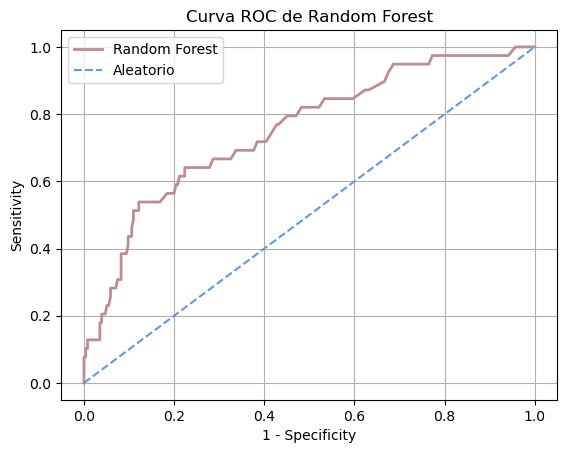

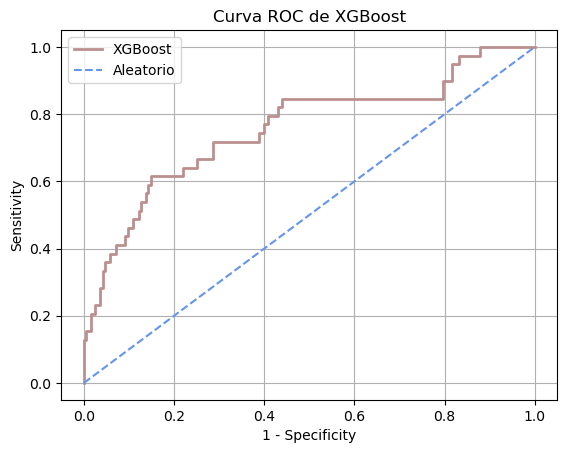

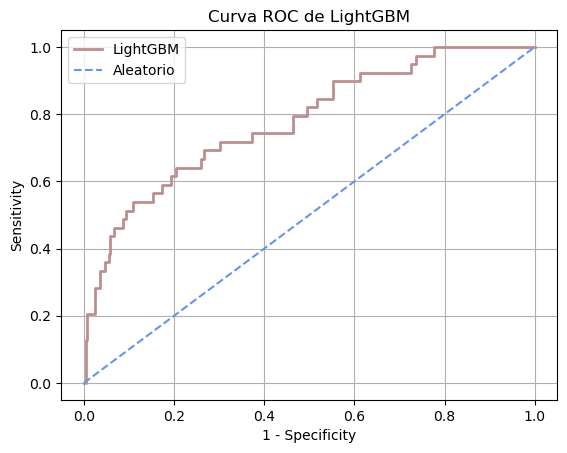

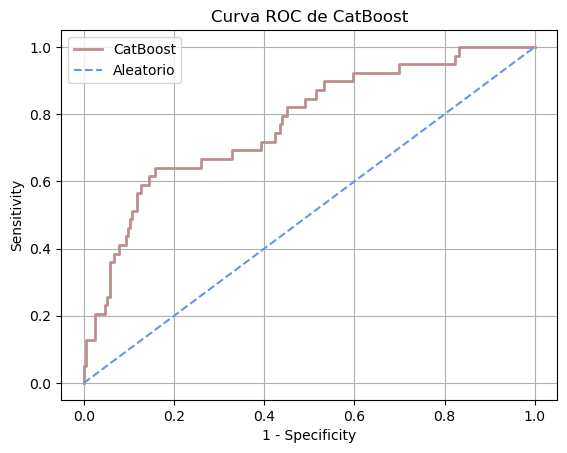

In [26]:
resultados = [predicciones, predicciones_rf, predicciones_xg, predicciones_light, predicciones_catboost]

for i, modelo in enumerate(modelos):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='rosybrown', lw=2)
    plt.plot([0, 1], [0, 1], color='cornflowerblue', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

### **AUC:**

In [27]:
tabla = pd.DataFrame({
    'DecisionTree': auc_dtc,
    'Random Forest': auc_rf,
    'XGBoost': auc_xg,
    'LightGBM': auc_light,
    'CatBoost': auc_cat
}, index=['AUC'])
tabla

,DecisionTree,Random Forest,XGBoost,LightGBM,CatBoost
AUC,0.593263,0.752438,0.758773,0.78009,0.773353


##### *Conclusiones:*